In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import abspath, dirname, join
import sys
from glob import glob
import random
import hydra
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from tqdm import tqdm
import torch

root = abspath(join(dirname("__file__"), '../../'))
sys.path.append(root)
from src.utils.common import load_obj, collate_fn, set_gpu
from src.utils.pytorch.utils import get_test_data_loader, set_seed
from src.models.predictor.detection.detector import Predictor
import matplotlib.pyplot as plt

# Initializing Hydra
There are several ways to initialize. See the [API docs](https://hydra.cc/docs/next/experimental/compose_api/#api-documentation) for full details.
All methods support both a function call style that changes the global state, and a context style that cleans up when theg scope exits.

## Global initialization
Calling each of the initilizaiton methods outside of a context changes the global state.

In [3]:
config_path = '../../configs'
config_name='test'

In [4]:
model_name = 'effdet_person_ca_v5'
model_folder = 'person' #'20200914_20_41_11'

In [5]:
# clear hyudra instance for running twice
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [6]:
initialize(config_path=config_path)
model_id = '${MODEL_ID}'
cfg = compose(overrides=[f'+experiment={model_name}', 'DATA.DATA_ID=demo_detection', 'MODEL_ID=pretrained_models', f'MODEL_PATH=models/{model_id}/{model_folder}/', 
                         'DATA.CSV_PATH=data/${DATA.DATA_ID}/split/train_folds_demo.csv', 'TEST.TEST_CSV_PATH=data/${DATA.DATA_ID}/interim/test_features.csv',
                         'DATA.TRAIN_IMAGE_DIR=data/${DATA.DATA_ID}/raw/train', 'TEST.TEST_IMAGE_DIR=data/${DATA.DATA_ID}/raw/test', 'AUGMENTATION.ALBUMENTATIONS.TEST.PATH=configs/augmentation/albumentations/test_augs_640_no_gt.yaml'], config_name=config_name)
print(cfg)

{'FRAMEWORK': 'pytorch', 'TASK': 'detection', 'MODEL_PATH': 'models/${MODEL_ID}/person/', 'TEST_ID': 'test', 'DATA': {'DATA_ID': 'demo_detection', 'TRAIN_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/train', 'EXTRACT_ONE_CLASS': False, 'PROCESSED_CSV_NAME': '_features.csv', 'CSV_PATH': 'data/${DATA.DATA_ID}/split/train_folds_demo.csv', 'RANDOM_KFOLD': False, 'TEST_SIZE': 0.2, 'N_FOLD': 1, 'FORMAT': 'pascal_voc', 'IMAGE_ID_COL_NAME': 'ImageID', 'FOLD_TARGET_COL': 'count', 'REMOVE_LARGE_BBOXES': False, 'LARGE_BBOX_AREA_THRESHOLD': 200000}, 'DATASET': {'CLASS_NAME': 'src.data.generator.detection.dataset.DatasetRetriever', 'CUTMIX': False}, 'TEST': {'BATCH_SIZE': 1, 'TEST_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/test', 'TEST_CSV_PATH': 'data/${DATA.DATA_ID}/interim/test_features.csv', 'VISUALIZE_RESULTS': True, 'VAL_PRED_IMG_DIR': 'pred_images/validation/', 'TEST_PRED_IMG_DIR': 'pred_images/test/', 'SAVE_ALL_IMAGES': False, 'DETECTION_THRESHOLD': 0.2, 'FIND_BEST_THR': True, 'ENSEMBLE_METHOD': 'WBF', 

# Check Pretrained Model

# Prediction

### Make Run dir for outputs (Only for Jupyter Notebook)
In Jupyter Notebook, Hydra does not make output folder automatically.

In [7]:
%cd ../../
run_dir = f'./models/{model_name}/demo/result/tutorial'
if not os.path.exists(run_dir):
    os.makedirs(run_dir, exist_ok=True)
    print(f'made directory: {run_dir}')

/data1/r_suzuki/pipeline/BaseModel


## Evaluate trained model on Validataion Dataset & Find best score threshold 

Run prediction on validation dataset to find best confidence score threshold.

### Get Trained Model Config

In [8]:
# 訓練時のモデルのコンフィグをロード
model_cfg_path = os.path.join('./', cfg.MODEL_PATH,'.hydra/config.yaml')
model_cfg = OmegaConf.load(model_cfg_path)

### Prepare Predictor

In [9]:
print('FRAMEWORK: ', cfg.FRAMEWORK)
print('TASK: ', cfg.TASK)

# GPUのセット
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device == torch.device('cuda'):
    gpu_id = [int(gid) for gid in cfg.SYSTEM.GPUS]
    set_gpu(gpu_id)

torch.backends.cudnn.enabled = cfg.SYSTEM.CUDNN.ENABLED
# seedの固定
if cfg.SYSTEM.SEED:
    set_seed(cfg)

predictor = Predictor(cfg, model_cfg, weight_dir = './' + cfg.MODEL_PATH)

FRAMEWORK:  pytorch
TASK:  detection
Loaded Finetuned model: ./models/pretrained_models/person//best_loss_fold0.pth
Loaded cofig for efficientdet_d4
Test Images Path: /data1/r_suzuki/pipeline/BaseModel/data/demo_detection/raw/test
Test Annotations Path: data/demo_detection/interim/test_features.csv


### Find Best Score Threshold on Validataion Dataset

**For Tutorial, There is no validation dataset to find best threshold, so skip this step**

In [10]:
# if cfg.TEST.FIND_BEST_THR:
#     print('-'*30, 'Evaluating on Validation dataset', '-'*30)
#     predictor.evaluate()

------------------------------ Evaluating on Validation dataset ------------------------------
------------------------------ Prediction: Validation Fold 0 ------------------------------


  0%|          | 0/2339 [00:00<?, ?it/s]

Train df length: 416397
Val df length: 5709
Framework: albumentations
Using transforms defined in yaml config file.
Score Threshold for Validation: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

-------------------- Finding best threshold for best score --------------------


  0%|          | 0/10 [00:00<?, ?it/s]

------------------------------
[Model Name]: pretrained_models
[Best Score Threshold]: 0.29
[OOF Score]: 0.6492
------------------------------
Best Score Threshold csv saved to: best_score_threshold.csv
Number of plot images: 10


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


## Prediction on Test Dataset

### Check test images

In [11]:
demo_data_dir = 'data/demo_detection/'
test_img_dir = os.path.join(os.getcwd(), demo_data_dir+'/raw/test')
print(test_img_dir)
test_images = glob(test_img_dir + '/*.jpg')
test_images = test_images[:10]

/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test


In [12]:
test_images

['/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/149a459813317be1.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/53235fa4c05102cb.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/7c33c6e015d44d6b.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/de2562ad4e4a657c.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/b75143a7ee175404.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/e0b3db284bfa2bdc.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/478d929a2ec56e03.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/844d25e32ef08450.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/50ef808aa89eec7a.jpg',
 '/data1/r_suzuki/pipeline/BaseModel/data/demo_detection//raw/test/4c654d7f4a8c2ccf.jpg']

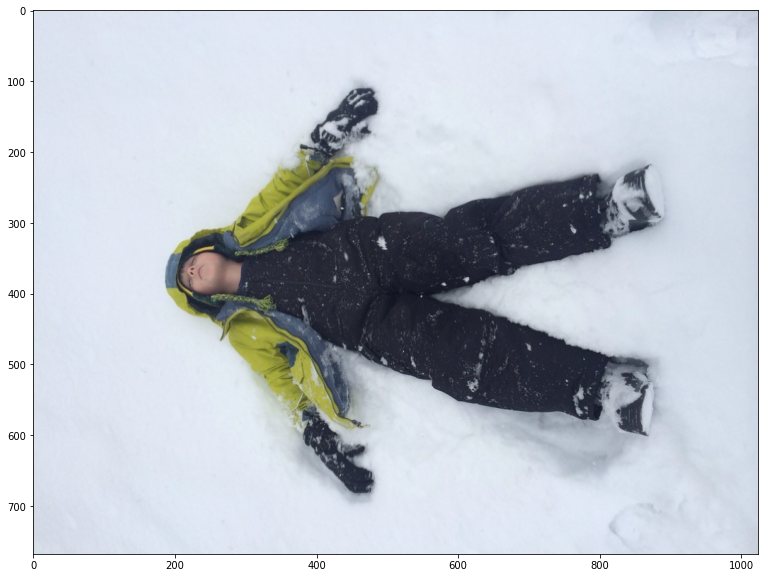

In [13]:
img = cv2.imread(test_images[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

### Prediction on Test Images

In [14]:
results = []
preds_list = []
for idx, image_path in tqdm(enumerate(test_images), total=len(test_images)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_id = image_path.split('/')[-1].split('.')[0]
    results, preds_list, gt_flag, score_threshold = predictor.predict_image(image=image, image_id=[str(image_id)], results=results, preds_list=preds_list, is_eval=True)
    
df = predictor.make_result_df(results, preds_list, gt_flag, score_threshold)

 70%|███████   | 7/10 [00:00<00:00,  8.25it/s]/data1/r_suzuki/.pyenv/versions/3.8.0/envs/detection_pipeline_v2/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
100%|██████████| 10/10 [00:01<00:00,  9.14it/s]

Made result dataframe [* No GT]


In [15]:
df.head()

image_id                                         image_path  \
0  53235fa4c05102cb  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   
1  7c33c6e015d44d6b  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   
2  7c33c6e015d44d6b  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   
3  7c33c6e015d44d6b  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   
4  de2562ad4e4a657c  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   

   class_id      conf  xmin  ymin  xmax  ymax  
0         1  0.894683   123    93   557   570  
1         1  0.832005   100    15   249   380  
2         1  0.773350   211     4   397   503  
3         1  0.698586   442    11   616   508  
4         1  0.669694   224    46   390   518

### Visualize Predictions

 50%|█████     | 5/10 [00:00<00:00, 40.99it/s]

Number of plot images: 10


100%|██████████| 10/10 [00:00<00:00, 44.59it/s]


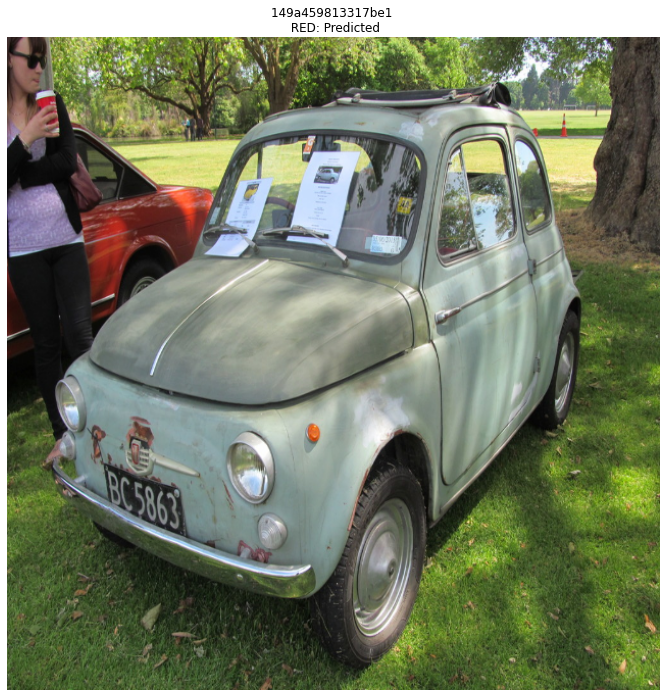

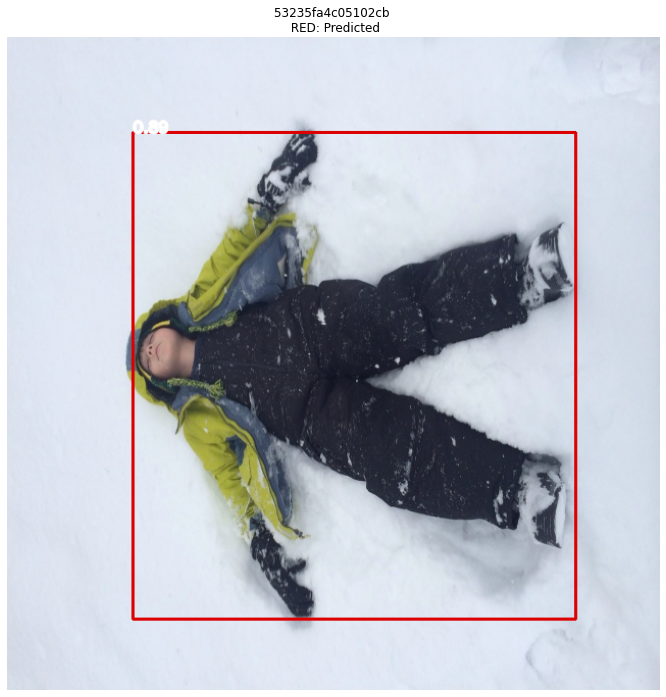

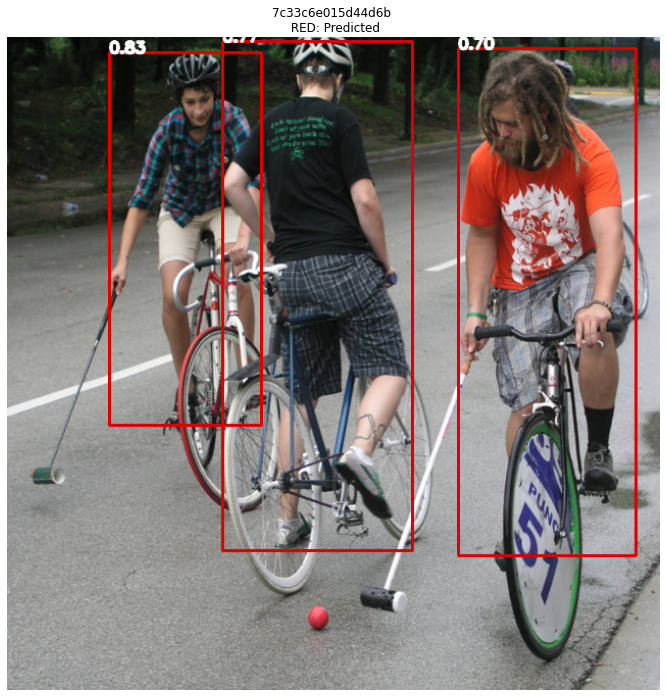

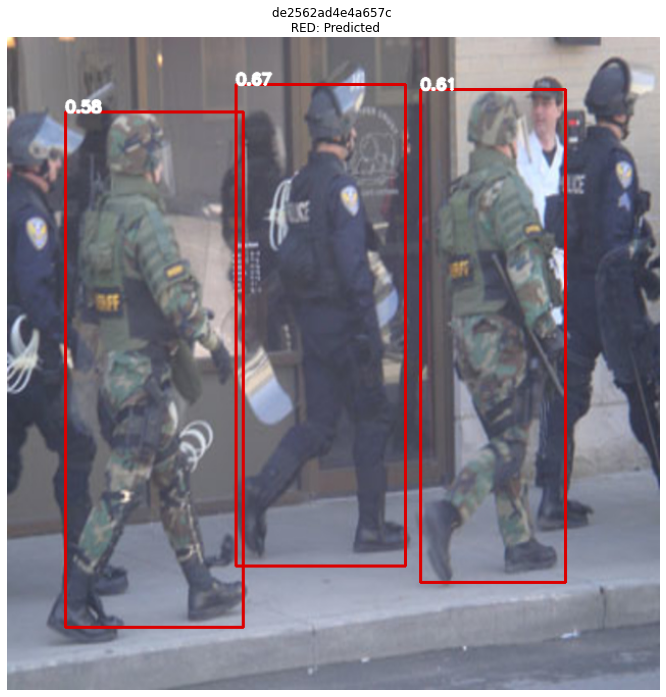

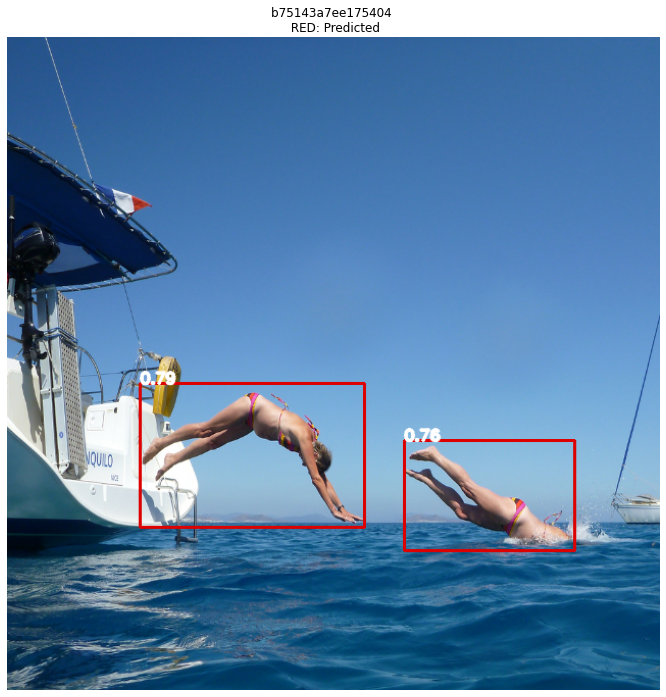

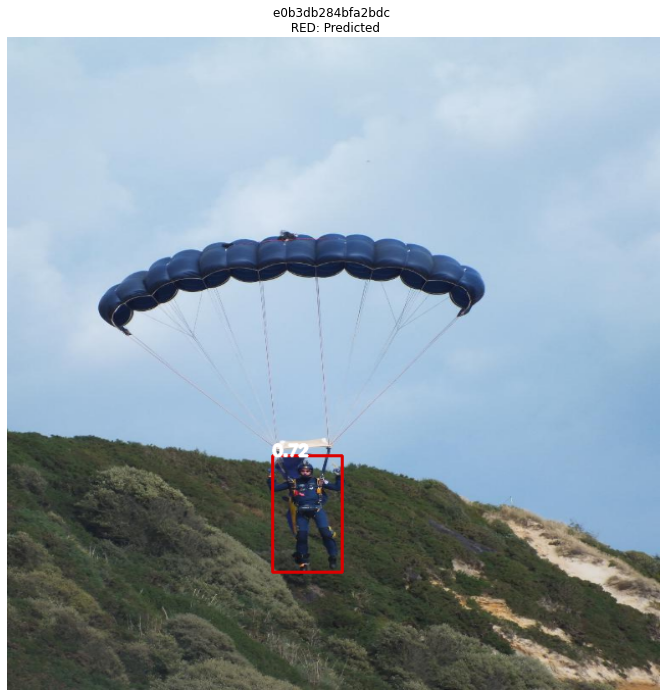

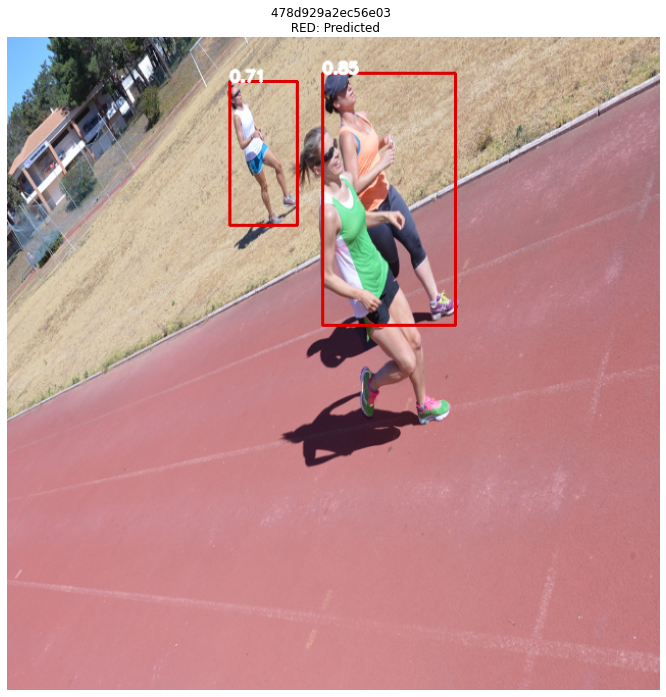

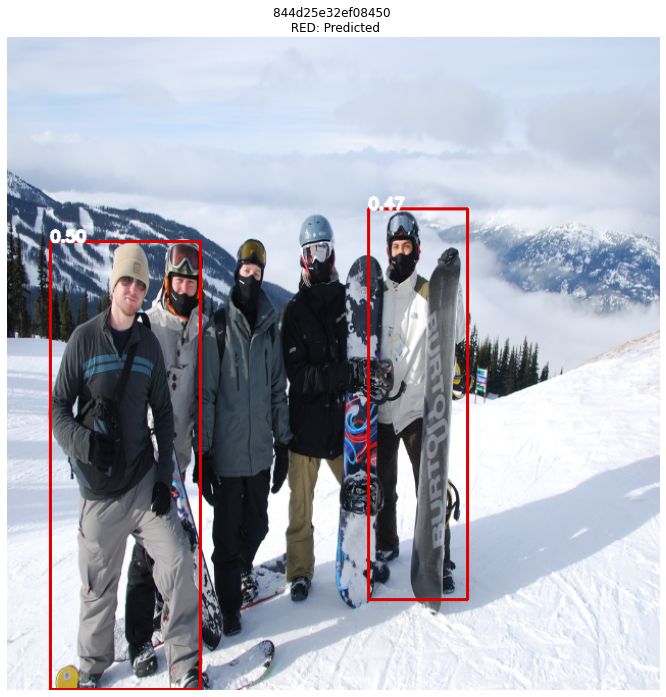

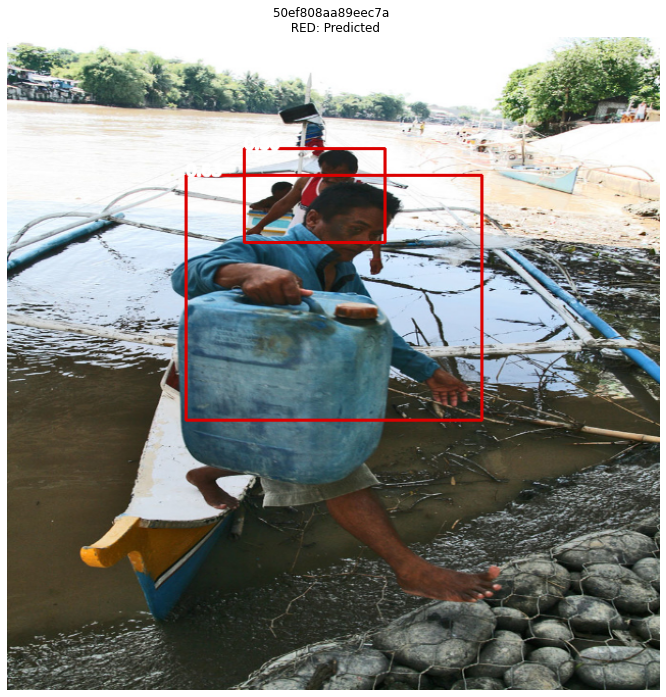

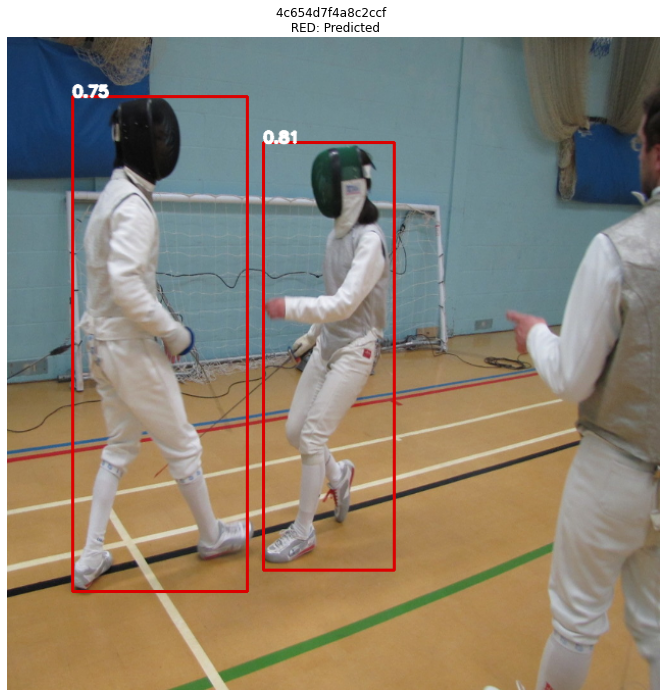

In [16]:
if cfg.TEST.VISUALIZE_RESULTS:
    predictor.visualize_results(preds_list, gt_flag, score_threshold, num_plot_images=10, save_images=False)

### Prediction on Test DataLoader

#### Prepare Test Dataset

In [17]:
test_gt_dir = os.path.join(os.getcwd(), demo_data_dir+'/interim')

test_df = pd.read_csv(test_gt_dir + '/test_features.csv', dtype={'image_id': str})

In [18]:
test_df.head()

image_id                                         image_path  \
0  149a459813317be1  data/demo_detection/raw/test/149a459813317be1.jpg   
1  149a459813317be1  data/demo_detection/raw/test/149a459813317be1.jpg   
2  149a459813317be1  data/demo_detection/raw/test/149a459813317be1.jpg   
3  53235fa4c05102cb  data/demo_detection/raw/test/53235fa4c05102cb.jpg   
4  7c33c6e015d44d6b  data/demo_detection/raw/test/7c33c6e015d44d6b.jpg   

     source  LabelName  Confidence      XMin      XMax      YMin      YMax  \
0  freeform  /m/01g317         1.0  0.267317  0.281302  0.117320  0.162474   
1  freeform  /m/01g317         1.0  0.279094  0.290135  0.118302  0.157566   
2  freeform  /m/01g317         1.0  0.290135  0.301176  0.117320  0.158548   
3  freeform  /m/01g317         1.0  0.181743  0.871283  0.143234  0.888668   
4  freeform  /m/01g317         1.0  0.151690  0.399178  0.021939  0.611598   

   IsOccluded  ...  class_id  image_height  image_width        xmin  \
0         0.0  ...         1         768.0       1024.0  273.732608   
1         0.0  ...         1         768.0       1024.0  285.792256   
2         0.0  ...         1         768.0       1024.0  297.098240   
3         0.0  ...         1         768.0       1024.0  186.104832   
4         0.0  ...         1         927.0       1024.0  155.330560   

         xmax        ymin        ymax       width      height           area  
0  288.053248   90.101760  124.780032   14.320640   34.678272     496.615049  
1  297.098240   90.855936  121.010688   11.305984   30.154752     340.929144  
2  308.404224   90.101760  121.764864   11.305984   31.663104     357.982547  
3  892.193792  110.003712  682.497024  706.088960  572.493312  404231.207277  
4  408.758272   20.337453  566.951346  253.427712  546.613893  138527.108250  

[5 rows x 24 columns]

### Run Prediction on DataLoader

#### Initialize Config with GT

In [19]:
# clear hyudra instance for running twice
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path=config_path)
model_id = '${MODEL_ID}'
cfg = compose(overrides=[f'+experiment={model_name}', f'MODEL_PATH=models/{model_id}/{model_folder}/'], config_name=config_name)

In [20]:
# get dataloader
test_data_loader = get_test_data_loader(cfg, model_cfg, test_df) 

df = predictor.predict(test_data_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

Framework: albumentations
Using transforms defined in yaml config file.
Using test dataset from args.


 70%|███████   | 7/10 [00:00<00:00,  6.55it/s]/data1/r_suzuki/.pyenv/versions/3.8.0/envs/detection_pipeline_v2/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
 10%|█         | 1/10 [00:00<00:01,  7.93it/s]

Number of plot images: 10


100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


------------------------------ Test Score ------------------------------
[Model Name]: pretrained_models
IoU Threshold: 0.4
Skip Box Threshold: 0.4
[Score Threshold]: 0.29
[mAP]: 0.6367
------------------------------------------------------------
Test score csv saved to: test_score.csv
Made result dataframe with GT.


In [21]:
df.head()

image_id gt_class_id gt_class_id     gt_xmin     gt_ymin  \
0  149a459813317be1           1   /m/01g317  273.732608   90.101760   
1  149a459813317be1           1   /m/01g317  285.792256   90.855936   
2  149a459813317be1           1   /m/01g317  297.098240   90.101760   
3  53235fa4c05102cb           1   /m/01g317  186.104832  110.003712   
4  7c33c6e015d44d6b           1   /m/01g317  155.330560   20.337453   

      gt_xmax     gt_ymax                                         image_path  \
0  288.053248  124.780032                                                NaN   
1  297.098240  121.010688                                                NaN   
2  308.404224  121.764864                                                NaN   
3  892.193792  682.497024  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   
4  408.758272  566.951346  /data1/r_suzuki/pipeline/BaseModel/data/demo_d...   

   class_id      conf   xmin  ymin   xmax   ymax  \
0       NaN       NaN    NaN   NaN    NaN    NaN   
1       NaN       NaN    NaN   NaN    NaN    NaN   
2       NaN       NaN    NaN   NaN    NaN    NaN   
3       1.0  0.894683  123.0  93.0  557.0  570.0   
4       1.0  0.832005  100.0  15.0  249.0  380.0   

                               confmat  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3  [0.9999999999999999, 0.0, 0.0, 0.0]  
4                 [3.0, 0.0, 0.0, 0.0]

### Visualize Predictions

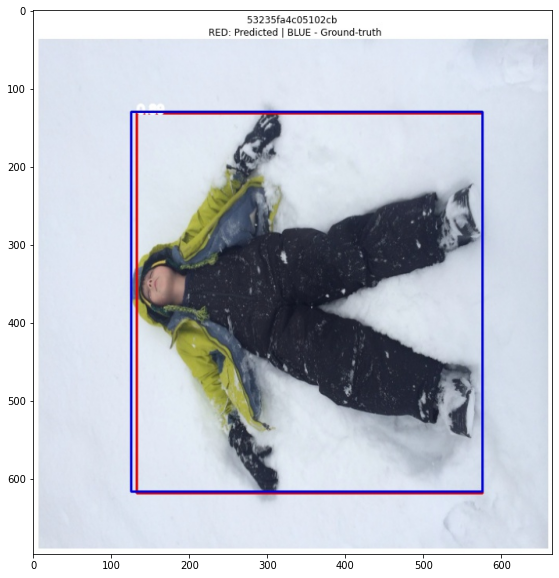

In [22]:
pred_img_dir = './pred_images/test'
pred_images = glob(pred_img_dir + '/*')
image_path = pred_images[0]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

### Check mAP Score and Thresholds in Saved CSV

In [23]:
score_df = pd.read_csv(cfg.TEST.TEST_SCORE_CSV_NAME)
score_df.head()

model_name  score_threshold   score  iou_threshold  \
0  pretrained_models             0.29  0.6367            0.4   

   skip_box_threshold  
0                 0.4

## Move Output Files to Results Directory (Only for Jupyter Notebook)

*In Jupyter Notebook, Hydra does not create run directory and current working directory is different than runnning these programs on ".py" file. <br>
So, you need to move output files from root directory manually.

### Check Outpus in Root Directory 

In [24]:
!pwd

/data1/r_suzuki/pipeline/BaseModel


In [25]:
!ls -lt

total 56
-rw-rw-r--  1 r_suzuki r_suzuki  104 Oct 15 12:30 test_score.csv
drwxrwxr-x  4 r_suzuki r_suzuki 4096 Oct 15 12:30 pred_images
-rw-rw-r--  1 r_suzuki r_suzuki   72 Oct 15 12:30 best_score_threshold.csv
drwxrwxr-x  3 r_suzuki r_suzuki 4096 Oct 15 12:26 augmentation
drwxrwxr-x 13 r_suzuki r_suzuki 4096 Oct 15 11:53 models
drwxrwxr-x  2 r_suzuki r_suzuki 4096 Oct 15 11:31 docs
drwxrwxr-x  2 r_suzuki r_suzuki 4096 Oct 13 13:47 requirements
drwxrwxr-x 15 r_suzuki r_suzuki 4096 Oct 13 13:45 configs
drwxrwxr-x  6 r_suzuki r_suzuki 4096 Oct 13 13:35 notebook
drwxrwxr-x  9 r_suzuki r_suzuki 4096 Oct 13 13:35 data
drwxrwxr-x  2 r_suzuki r_suzuki 4096 Oct 13 13:20 bin
-rw-rw-r--  1 r_suzuki r_suzuki  286 Oct 13 13:20 README.md
drwxrwxr-x  8 r_suzuki r_suzuki 4096 Aug 28 15:01 src
drwxrwxr-x  2 r_suzuki r_suzuki 4096 Aug 28 15:01 tests


### Move Outputs to Results Directory

In [26]:
out_files = ['augmentation', '*.csv', 'pred_images']
for file in out_files:
    if os.path.exists(run_dir + f'/{file}'):
        !rm -r ./$file
    else:
        !mv ./$file $run_dir

In [27]:
!ls

README.md  bin	configs  data  docs  models  notebook  requirements  src  tests


### Outputs

In [28]:
print(run_dir)
!ls $run_dir -lt

./models/effdet_person_ca_v5/demo/result/tutorial
total 16
-rw-rw-r-- 1 r_suzuki r_suzuki  104 Oct 15 12:30 test_score.csv
-rw-rw-r-- 1 r_suzuki r_suzuki   72 Oct 15 12:30 best_score_threshold.csv
drwxrwxr-x 3 r_suzuki r_suzuki 4096 Oct 13 19:44 augmentation
drwxrwxr-x 4 r_suzuki r_suzuki 4096 Oct 13 19:44 pred_images
